In [1]:
#Importing all the libraries
using SpecialFunctions
using LinearAlgebra
using DataFrames
using StatsPlots
using ProgressMeter
using CSV
theme(:dao)
ProgressMeter.ijulia_behavior(:clear)

function scurve(x)  #Function for an S shaped curve, used inside survival function
    return 1/(1 + exp(-11 * (x - 0.5)))
end

scurve (generic function with 1 method)

In [2]:
global DOMINANT = false        #Switch between 1 being dominant or recessive
SHAPE = "linear"                  #Shape of survival function

P = Dict(
    "pm" => 0.01,       #Proportion of 1 for male locus
    "pf" => 0.01,       #Proportion of 1 for female locus
    "C" => 20,          #Eggs laid by non defender females
    "c" => 14,          #Eggs laid by defender females
    "a" => 2,           #Advantege for non defender males
    "u" => 0.1,         #Probability of female staying unmated
    "r" => 0.1,         #Ratio of males in a female male mating
    "x" => 0.2          #Prob. m11 changing their expression
    )

function s(d, use = "exp")      #Probability of survival given the proportion of defenders in the offsprings
    if use == "linear"
        return d * (0.9 - 0.1) + 0.1
    elseif use == "expinv"
        return ((exp(-d * 2.5) - exp(0))/(exp(-1 * 2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "exp"
        return ((exp(2.5*d) - exp(0))/(exp(2.5) - exp(0))) * (0.9 - 0.1) + 0.1
    elseif use == "s"
        return ((scurve(d) - scurve(0)) / (scurve(1) - scurve(0))) * (0.9 - 0.1) + 0.1
    elseif use == "relu"
        return minimum(0.9, maximum(0.1, d^1.5))
    end
end

s (generic function with 2 methods)

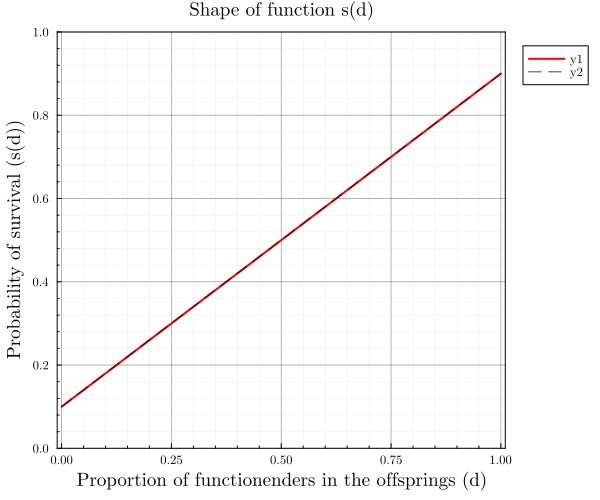

In [3]:
#Plotting the shape of survival function
d = range(0, stop=1, length=101)
plot(d, s.(d, SHAPE), lw = 2, lc=:red, size = (600,500))
plot!(d, range(0.1, stop=0.9, length=101), linestyle=:dash, color=:black, alpha=0.5, lw = 1.5)
xlims!(-0.01,1.01)
ylims!(0.0, 1)
xlabel!("Proportion of functionenders in the offsprings (d)")
ylabel!("Probability of survival (s(d))")
title!("Shape of function s(d)")

In [4]:
#Modular functions for different loops
function F(u, f, m, c, S) #Calculating the overall numberr of offsprings
    return u * f * m * c * S
end

function S1(c, r)
    k = collect(0:c)
    S = sum(binomial.(c, k) .* (((r).^k).*((1-r).^(c.-k))) .* s.(k/c, SHAPE))
    return S
end

function S2(c, r1, r2, case = 1)
    if case == 1
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.(m/c, SHAPE))
            S +=  mul1 * Sm
        end
    elseif case == 2
        S = 0
        for k in 0:c
            mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
            m = collect(0:k)
            Sm = sum(binomial.(k, m) .* (((r2).^m).*((1-r2).^(k.-m))) .* s.((m .+ (c - k))/c, SHAPE))
            S +=  mul1 * Sm
        end
    end
    return S
end

function S3(c, r1, r2, r3)
    S = 0
    for k in 0:c
        mul1 = binomial.(c, k) * (((r1).^k).*((1-r1).^(c-k)))
        for m in 0:k
            mul2 = binomial.(k, m) * (((r2).^m).*((1-r2).^(k-m)))
            f = collect(0:c-k)
            Sf = sum(binomial.(c-k, f) .* (((r3).^f).*((1-r3).^(c-k.-f))) .* s.((f.+m)/c, SHAPE))
            S += mul1 * mul2 * Sf
        end
    end
    return S
end


S3 (generic function with 1 method)

In [51]:
#Functions to define mating interactions
#Non Matings
function f00(P) #m00
    return F(P["u"], P["f00"], 1, P["C"], s(0, SHAPE))
end

function f01(P) #m00; m01
    return F(P["u"], P["f01"], 1, P["C"], s(0, SHAPE))
end

function f02(P) #m01
    return F(P["u"], P["f02"], 1, P["C"], s(0, SHAPE))
end

function f10(P) #m00; m10
    return F(P["u"], P["f10"], 1, DOMINANT ? P["c"] : P["C"], S1(DOMINANT ? P["c"] : P["C"], 0.5))
end

function f11(P) #m11; m10; m01; m00
    S = 0
    c = DOMINANT ? P["c"] : P["C"]
    for k in 0:c
        mul1 = binomial.(c, k) * ((0.5).^c)
        m = collect(0:k)
        Sm = sum(binomial.(k, m) .* ((0.5).^k) .* s.((k .- (P["x"] .* m))/c, SHAPE))
        S +=  mul1 * Sm
    end
    
    return F(P["u"], P["f11"], 1, DOMINANT ? P["c"] : P["C"], S)
end

function f12(P) #m11; m01
    c = DOMINANT ? P["c"] : P["C"]
    k = collect(0:c)
    S = sum(binomial.(c, k) .* ((0.5).^c) .* s.(((1 - P["x"]) .* k)/c, SHAPE))

    return F(P["u"], P["f12"], 1, DOMINANT ? P["c"] : P["C"], S)
end

function f20(P) #m10
    return F(P["u"], P["f20"], 1, P["c"], s(1, SHAPE))
end

function f21(P) #m11; m10
    c = P["c"]
    k = collect(0:c)
    S = sum(binomial.(c, k) .* ((0.5).^c) .* s.((c .- (P["x"] .* k))/c, SHAPE))

    return F(P["u"], P["f21"], 1, P["c"], S)
end

function f22(P) #m11
    return F(P["u"], P["f22"], 1, P["c"], s(((1-P["x"]).* P["c"])/P["c"], SHAPE))
end


f22 (generic function with 1 method)

In [52]:
#Matings
#With m(00)
function f00m00(P) #f00; m00
    return F(1 - P["u"], P["f00"], P["m00"], P["C"], s(0, SHAPE))
end

function f01m00(P) #f01; f00; m01; m00
    return F(1 - P["u"], P["f01"], P["m00"], P["C"], s(0, SHAPE))
end

function f02m00(P) #f01; m01
    return F(1 - P["u"], P["f02"], P["m00"], P["C"], s(0, SHAPE))
end

function f10m00(P) #f10; f00; m10; m00
    return F(1 - P["u"], P["f10"], P["m00"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S3(P["c"], P["r"], 0.5, 0.5) : S2(P["C"], P["r"], 0.5, 1))
end

function f11m00(P) #f11; f01; f10; f00; m11; m10; m01; m00
    S = 0
    c = DOMINANT ? P["c"] : P["C"]
    if !DOMINANT
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            for md in 0:m
                mul2 = binomial.(m, md) * ((0.5).^m)
                mm = collect(0:md)
                Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((md .- (P["x"] .* mm))/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * ((0.5).^f)
                for md in 0:c-f
                    mul3 = binomial.(c-f, md) * ((0.5).^(c-f))
                    mm = collect(0:md)
                    Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((fd + md .- (P["x"] .* mm))/c, SHAPE))
                    S += mul1 * mul2 * mul3 * Smm
                end
            end
        end
    end 

    return F(1 - P["u"], P["f11"], P["m00"], DOMINANT ? P["c"] : P["C"], S)
end

function f12m00(P) #f11; f01; m11; m01
    S = 0
    c = DOMINANT ? P["c"] : P["C"]

    if DOMINANT
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * (((0.5).^fd).*((0.5).^(f-fd)))
                mm = collect(0:c-f)
                Smm = sum(binomial.(c-f, mm) .* (((0.5).^mm).*((0.5).^(c-f.-mm))) .* s.((fd .+ (1 .- P["x"]).*mm)/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    else
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.(((1 .- P["x"]) .* mm)/c, SHAPE))
            S +=  mul1 * Smm
        end
    end
        
    return F(1 - P["u"], P["f12"], P["m00"], DOMINANT ? P["c"] : P["C"], S)
end

function f20m00(P) #f10; m10
    return F(1 - P["u"], P["f20"], P["m00"], P["c"], DOMINANT ? s(1, SHAPE) : S1(P["c"], P["r"]))
end

function f21m00(P) #f11; f10; m11; m10
    S = 0
    c = P["c"]
    if DOMINANT
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
            S += mul1 * Smm
        end
    else
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((m .- (P["x"] .* mm))/c, SHAPE))
            S += mul1 * Smm
        end
    end

    return F(1 - P["u"], P["f21"], P["m00"], P["c"], S)
end

function f22m00(P) #f11; m11
    S = 0
    c = P["c"]
    if DOMINANT
        mm = collect(0:c)
        S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.((c .- (P["x"].*mm))/c, SHAPE))
    else        
        mm = collect(0:c)
        S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.(((1 - P["x"]).*mm)/c, SHAPE))
    end
    
    return F(1 - P["u"], P["f22"], P["m00"], P["c"], S)
end

f22m00 (generic function with 1 method)

In [53]:
#Matings
#With m(01)
function f00m01(P) #f01; m00
    return F(1 - P["u"], P["f00"], P["m01"], P["C"], s(0, SHAPE))
end

function f01m01(P) #f02; f01; m01; m00
    return F(1 - P["u"], P["f01"], P["m01"], P["C"], s(0, SHAPE))
end

function f02m01(P) #f02; m01
    return F(1 - P["u"], P["f02"], P["m01"], P["C"], s(0, SHAPE))
end

function f10m01(P) #f11; f01; m10; m00
    return F(1 - P["u"], P["f10"], P["m01"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S3(P["c"], P["r"], 0.5, 0.5) : S2(P["C"], P["r"], 0.5, 1))
end

function f11m01(P) #f12; f02; f11; f01; m11; m10; m01; m00
    S = 0
    c = DOMINANT ? P["c"] : P["C"]
    if !DOMINANT
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            for md in 0:m
                mul2 = binomial.(m, md) * ((0.5).^m)
                mm = collect(0:md)
                Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((md .- (P["x"] .* mm))/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * ((0.5).^f)
                for md in 0:c-f
                    mul3 = binomial.(c-f, md) * ((0.5).^(c-f))
                    mm = collect(0:md)
                    Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((fd .+ md .- (P["x"] .* mm))/c, SHAPE))
                    S += mul1 * mul2 * mul3 * Smm
                end
            end
        end
    end

    return F(1 - P["u"], P["f11"], P["m01"], DOMINANT ? P["c"] : P["C"], S)
end

function f12m01(P) #f12; f02; m11; m01
    S = 0
    c = DOMINANT ? P["c"] : P["C"]

    if DOMINANT
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * (((0.5).^fd).*((0.5).^(f-fd)))
                mm = collect(0:c-f)
                Smm = sum(binomial.(c-f, mm) .* (((0.5).^mm).*((0.5).^(c-f.-mm))) .* s.((fd .+ (1-P["x"]).*mm)/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    else
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.(((1 - P["x"]) .* mm)/c, SHAPE))
            S +=  mul1 * Smm
        end
    end

    return F(1 - P["u"], P["f12"], P["m01"], DOMINANT ? P["c"] : P["C"], S)
end

function f20m01(P) #f11; m10
    return F(1 - P["u"], P["f20"], P["m01"], P["c"], DOMINANT ? s(1, SHAPE) : S1(P["c"], P["r"]))
end

function f21m01(P) #f12; f11; m11; m10
    S = 0
    c = P["c"]
    if DOMINANT
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
            S += mul1 * Smm
        end
    else
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((m .- (P["x"] .* mm))/c, SHAPE))
            S += mul1 * Smm
        end
    end

    return F(1 - P["u"], P["f21"], P["m01"], P["c"], S)
end

function f22m01(P) #f12; m11
    S = 0
    c = P["c"]
    if DOMINANT
        mm = collect(0:c)
        S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.((c .- (P["x"].*mm))/c, SHAPE))
    else        
        mm = collect(0:c)
        S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.(((1 .- P["x"]).*mm)/c, SHAPE))
    end
    
    return F(1 - P["u"], P["f22"], P["m01"], P["c"], S)
end

f22m01 (generic function with 1 method)

In [63]:
#Matings
#With m(10)
function f00m10(P) #f10; m00
    return F(1 - P["u"], P["f00"], P["m10"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f01m10(P) #f11; f10; m01; m00
    return F(1 - P["u"], P["f01"], P["m10"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f02m10(P) #f11; m01
    return F(1 - P["u"], P["f02"], P["m10"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f10m10(P) #f20; f10; m10; m00
    return F(1 - P["u"], P["f10"], P["m10"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], P["r"], 0.5, 2) : S3(P["c"], P["r"], 0.5, 0.5))
end

function f11m10(P) #f21; f11; f20; f10; m11; m10; m01; m00
    S = 0
    c = DOMINANT ? P["c"] : P["C"]

    if DOMINANT
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            for md in 0:m
                mul2 = binomial.(m, md) * ((0.5).^m)
                mm = collect(0:md)
                Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.(((c - m) .+ (md .- (P["x"] .* mm)))/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end

    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * ((0.5).^f)
                for md in 0:c-f
                    mul3 = binomial.(c-f, md) * ((0.5).^(c-f))
                    mm = collect(0:md)
                    Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((fd .+ md .- (P["x"] .* mm))/c, SHAPE))
                    S += mul1 * mul2 * mul3 * Smm
                end
            end
        end
    end

    return F(1 - P["u"], P["f11"], P["m10"], DOMINANT ? P["c"] : P["C"], S)
end

function f12m10(P) #f21; f11; m11; m01
    S = 0
    c = DOMINANT ? P["c"] : P["C"]
    if DOMINANT
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m) .* ((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.(((c - m) .+ (1 .- P["x"]) .* mm)) / c, SHAPE)
            S += mul1 * Smm
        end
    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * (((0.5).^fd).*((0.5).^(f-fd)))
                mm = collect(0:c-f)
                Smm = sum(binomial.(c-f, mm) .* (((0.5).^mm) .* ((0.5).^(c-f.-mm))) .* s.((fd .+ (1-P["x"]) .* mm)/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    end

    return F(1 - P["u"], P["f12"], P["m10"], DOMINANT ? P["c"] : P["C"], S)
end

function f20m10(P) #f20; m10
    return F(1 - P["u"], P["f20"], P["m10"], P["c"], s(1, SHAPE))
end

function f21m10(P) #f21; f20; m11; m10
    S = 0
    c = P["c"]
    for m in 0:c
        mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
        mm = collect(0:m)
        Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
        S += mul1 * Smm
    end

    return F(1 - P["u"], P["f21"], P["m10"], P["c"], S)
end

function f22m10(P) #f21; m11
    c = P["c"]
    mm = collect(0:c)
    S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
    return F(1 - P["u"], P["f22"], P["m10"], P["c"], S)
end

f22m10 (generic function with 1 method)

In [64]:
#Matings
#With m(11)
function f00m11(P) #f11; m00
    return F(1 - P["u"], P["f00"], P["m11"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f01m11(P) #f12; f11; m01; m00
    return F(1 - P["u"], P["f01"], P["m11"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end
 
function f02m11(P) #f12; m01
    return F(1 - P["u"], P["f02"], P["m11"], P["C"], DOMINANT ? S1(P["C"], 1-P["r"]) : s(0, SHAPE))
end

function f10m11(P) #f21; f11; m10; m00
    return F(1 - P["u"], P["f10"], P["m11"], DOMINANT ? P["c"] : P["C"], DOMINANT ? S2(P["c"], P["r"], 0.5, 2) : S3(P["c"], P["r"], 0.5, 0.5))
end

function f11m11(P) #f22; f12; f21; f11; m11; m10; m01; m00
    S = 0
    c = DOMINANT ? P["c"] : P["C"]

    if DOMINANT
        for m in 0:c
            mul1 = binomial.(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
            for md in 0:m
                mul2 = binomial.(m, md) * ((0.5).^m)
                mm = collect(0:md)
                Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.(((c - m) .+ (md .- (P["x"] .* mm)))/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end

    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * ((0.5).^f)
                for md in 0:c-f
                    mul3 = binomial.(c-f, md) * ((0.5).^(c-f))
                    mm = collect(0:md)
                    Smm = sum(binomial.(md, mm) .* ((0.5).^md) .* s.((fd .+ md .- (P["x"] .* mm))/c, SHAPE))
                    S += mul1 * mul2 * mul3 * Smm
                end
            end
        end
    end

    return F(1 - P["u"], P["f11"], P["m11"], DOMINANT ? P["c"] : P["C"], S)
end

function f12m11(P) #f22; f12; m11; m01
    S = 0
    c = DOMINANT ? P["c"] : P["C"]
    if DOMINANT
        for m in 0:c
            mul1 = binomial(c, m) * (((P["r"]).^m) .* ((1-P["r"]).^(c-m)))
            mm = collect(0:m)
            Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.(((c-m) .+ (1-P["x"]) .* mm)) / c, SHAPE)
            S += mul1 * Smm
        end
    else
        for f in 0:c
            mul1 = binomial.(c, f) * (((1-P["r"]).^f).*((P["r"]).^(c-f)))
            for fd in 0:f
                mul2 = binomial.(f, fd) * (((0.5).^fd).*((0.5).^(f-fd)))
                mm = collect(0:c-f)
                Smm = sum(binomial.(c-f, mm) .* (((0.5).^mm).*((0.5).^(c-f.-mm))) .* s.((fd .+ (1-P["x"]) .* mm)/c, SHAPE))
                S += mul1 * mul2 * Smm
            end
        end
    end

    return F(1 - P["u"], P["f12"], P["m11"], DOMINANT ? P["c"] : P["C"], S)
end

function f20m11(P) #f21; m10
    return F(1 - P["u"], P["f20"], P["m11"], P["c"], s(1, SHAPE))
end

function f21m11(P) #f22; f21; m11; m10
    S = 0
    c = P["c"]
    for m in 0:c
        mul1 = binomial(c, m) * (((P["r"]).^m).*((1-P["r"]).^(c-m)))
        mm = collect(0:m)
        Smm = sum(binomial.(m, mm) .* ((0.5).^m) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
        S += mul1 * Smm
    end

    return F(1 - P["u"], P["f21"], P["m11"], P["c"], S)
end

function f22m11(P) #f22; m11
    c = P["c"]
    mm = collect(0:c)
    S = sum(binomial.(c, mm) .* (((P["r"]).^mm).*((1-P["r"]).^(c.-mm))) .* s.((c .- (P["x"] .* mm))/c, SHAPE))
    return F(1 - P["u"], P["f22"], P["m11"], P["c"], S)
end

f22m11 (generic function with 1 method)

In [65]:
#Function to find the number of offsprings in the next generation based on all the interactions
function nexgen(P, females = [], males = [])
    #Initial frequencies of all genotypes
    if length(females) == 0 || length(males) == 0
        #Males
        m00 = (1 - P["pf"])*(1 - P["pm"])
        m01 = (1 - P["pf"])*P["pm"]
        m10 = P["pf"]*(1 - P["pm"])
        m11 = P["pf"]*P["pm"]

        tot_eff = ((m01 + m11) + (P["a"] * (m00 + m10)))

        P["m00"] = (P["a"] * m00) / tot_eff
        P["m01"] = m01 / tot_eff
        P["m10"] = (P["a"] * m10) / tot_eff
        P["m11"] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = ((1 - P["pf"])^2) * ((1 - P["pm"])^2)
        P["f01"] = ((1 - P["pf"])^2) * (2*P["pm"]*(1-P["pm"]))
        P["f02"] = ((1 - P["pf"])^2) * (P["pm"]^2)

        P["f10"] = (2*(1 - P["pf"])*P["pf"]) * ((1 - P["pm"])^2)
        P["f11"] = (2*(1 - P["pf"])*P["pf"]) * (2*P["pm"]*(1-P["pm"]))
        P["f12"] = (2*(1 - P["pf"])*P["pf"]) * (P["pm"]^2)

        P["f20"] = (P["pf"]^2) * ((1 - P["pm"])^2)
        P["f21"] = (P["pf"]^2) * (2*P["pm"]*(1-P["pm"]))
        P["f22"] = (P["pf"]^2) * (P["pm"]^2)


    else
        #Males
        m00 = males[1] + males[5]
        m01 = males[2] + males[6]
        m10 = males[3] + males[7]
        m11 = males[4] + males[8]

        tot_eff = ((m01 + m11) + (P["a"] * (m00 + m10)))

        P["m00"] = (P["a"] * m00) / tot_eff
        P["m01"] = m01 / tot_eff
        P["m10"] = (P["a"] * m10) / tot_eff
        P["m11"] = m11 / tot_eff

        #Females (Assuming equilibrium values)
        P["f00"] = females[1]
        P["f01"] = females[2]
        P["f02"] = females[3]
        
        P["f10"] = females[4]
        P["f11"] = females[5]
        P["f12"] = females[6]

        P["f20"] = females[7]
        P["f21"] = females[8]
        P["f22"] = females[9]
    end



    #Next Generation
    #Females
    f00_n = (1 - P["r"]) * (f00m00(P) + 0.5 * (f01m00(P) + f10m00(P) + 0.5 * f11m00(P)))

    f01_n = (1 - P["r"]) * (f00m01(P) + f02m00(P) + 0.5 * (f01m00(P) + f01m01(P) + f10m01(P) + f12m00(P) + 0.5 * (f11m00(P) + f11m01(P))))

    f02_n = (1 - P["r"]) * (f02m01(P) + 0.5 * (f01m01(P) + f12m01(P) + 0.5 * f11m01(P)))

    f10_n = (1 - P["r"]) * (f00m10(P) + f20m00(P) + 0.5 * (f01m10(P) + f21m00(P) + f10m00(P) + f10m10(P) + 0.5 * (f11m00(P) + f11m10(P))))

    f11_n = (1 - P["r"]) * (f00m11(P) + f02m10(P) + f20m01(P) + f22m00(P) + 0.5 * (f01m10(P) + f01m11(P) + f21m00(P) + f21m01(P) + f10m01(P) + f10m11(P) + f12m00(P) + f12m10(P) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    f12_n = (1 - P["r"]) * (f02m11(P) + f22m01(P) + 0.5 * (f01m11(P) + f21m01(P) + f12m01(P) + f12m11(P) + 0.5 * (f11m01(P) + f11m11(P))))

    f20_n = (1 - P["r"]) * (f20m10(P) + 0.5 * (f21m10(P) + f10m10(P) + 0.5 * f11m10(P)))

    f21_n = (1 - P["r"]) * (f20m11(P) + f22m10(P) + 0.5 * (f21m10(P) + f21m11(P) + f10m11(P) + f12m10(P) + 0.5 * (f11m10(P) + f11m11(P))))

    f22_n = (1 - P["r"]) * (f22m11(P) + 0.5 * (f21m11(P) + f12m11(P) + 0.5 * f11m11(P)))


    #Males
    m00_n_nm = f00(P) + 0.5 * (f01(P) + f10(P) + 0.5 * f11(P))

    m01_n_nm = f02(P) + 0.5 * (f01(P) + f12(P) + 0.5 * f11(P))
    
    m10_n_nm = f20(P) + 0.5 * (f21(P) + f10(P) + 0.5 * f11(P))
    
    m11_n_nm = f22(P) + 0.5 * (f21(P) + f12(P) + 0.5 * f11(P))

    m00_n_m = P["r"] * ((f00m00(P) + f00m01(P) + f00m10(P) + f00m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    m01_n_m = P["r"] * ((f02m00(P) + f02m01(P) + f02m10(P) + f02m11(P)) + 0.5 * ((f01m00(P) + f01m01(P) + f01m10(P) + f01m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m10_n_m = P["r"] * ((f20m00(P) + f20m01(P) + f20m10(P) + f20m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f10m00(P) + f10m01(P) + f10m10(P) + f10m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))
    
    m11_n_m = P["r"] * ((f22m00(P) + f22m01(P) + f22m10(P) + f22m11(P)) + 0.5 * ((f21m00(P) + f21m01(P) + f21m10(P) + f21m11(P)) + (f12m00(P) + f12m01(P) + f12m10(P) + f12m11(P)) + 0.5 * (f11m00(P) + f11m01(P) + f11m10(P) + f11m11(P))))

    #Creating a list for number of all organisms in next generation
    female_ls = [f00_n, f01_n, f02_n, f10_n, f11_n, f12_n, f20_n, f21_n, f22_n]
    male_ls = [m00_n_nm, m01_n_nm, m10_n_nm, m11_n_nm, m00_n_m, m01_n_m, m10_n_m, m11_n_m]

    return female_ls, male_ls
end

nexgen (generic function with 3 methods)

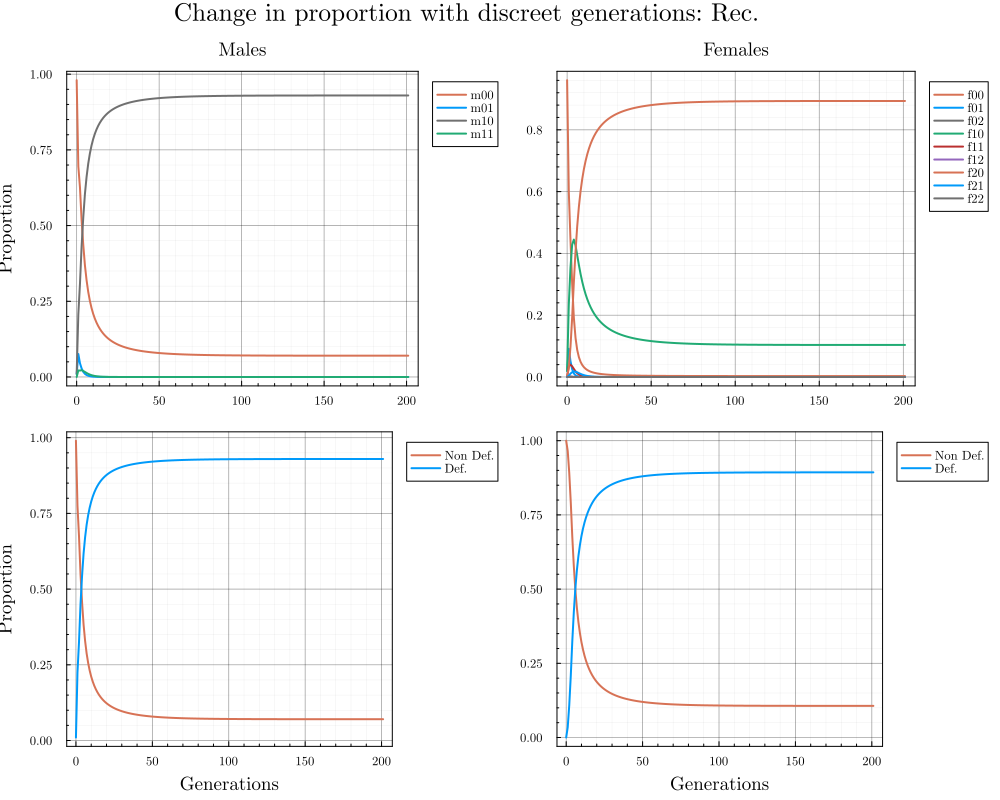

In [66]:
#Simulating proportions of each individual over a generation time
DOMINANT = false   #This simulation is for the recessive case
SHAPE = "linear"      #Shape for the survival function being used is exponential
gentime = 200

param = copy(P)    #Copying the main param dictionary to avoid making any changes to it
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 8
param["a"] = 2.58

param["u"] = 0.1
param["r"] = 0.475

females = []
males = []

ind_prop = Dict(      #Dictionary storing the proportion of indivduals at each generation
    "m00" => [(1 - P["pf"])*(1 - P["pm"])],
    "m01" => [(1 - P["pf"])*(P["pm"])],
    "m10" => [(P["pf"])*(1 - P["pm"])],
    "m11" => [(P["pf"])*(P["pm"])],

    "f00" => [((1 - P["pf"])^2) * ((1 - P["pm"])^2)],
    "f01" => [((1 - P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f02" => [((1 - P["pf"])^2) * ((P["pm"])^2)],

    "f10" => [(P["pf"] * (1 - P["pf"]) * 2) * ((1 - P["pm"])^2)],
    "f11" => [(P["pf"] * (1 - P["pf"]) * 2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f12" => [(P["pf"] * (1 - P["pf"]) * 2) * ((P["pm"])^2)],

    "f20" => [((P["pf"])^2) * ((1 - P["pm"])^2)],
    "f21" => [((P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f22" => [((P["pf"])^2) * ((P["pm"])^2)]
)

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m00"], (male_ls[1] + male_ls[5]) / sum(male_ls))
    push!(ind_prop["m01"], (male_ls[2] + male_ls[6]) / sum(male_ls))
    push!(ind_prop["m10"], (male_ls[3] + male_ls[7]) / sum(male_ls))
    push!(ind_prop["m11"], (male_ls[4] + male_ls[8]) / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f02"], female_ls[3] / sum(female_ls))

    push!(ind_prop["f10"], female_ls[4] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[5] / sum(female_ls))
    push!(ind_prop["f12"], female_ls[6] / sum(female_ls))

    push!(ind_prop["f20"], female_ls[7] / sum(female_ls))
    push!(ind_prop["f21"], female_ls[8] / sum(female_ls))
    push!(ind_prop["f22"], female_ls[9] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m00"] ind_prop["m01"] ind_prop["m10"] ind_prop["m11"]], labels = ["m00" "m01" "m10" "m11"], lw = 2, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f02"] ind_prop["f10"] ind_prop["f11"] ind_prop["f12"] ind_prop["f20"] ind_prop["f21"] ind_prop["f22"]], labels = ["f00" "f01" "f02" "f10" "f11" "f12" "f20" "f21" "f22"], lw = 2, title = "Females")
p3 = plot(rng, [(ind_prop["m00"] .+ ind_prop["m01"] .+ (param["x"] .* ind_prop["m11"])) (((1-param["x"]) .* ind_prop["m11"]) .+ ind_prop["m10"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"] .+ ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"]) (ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"]) (ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"] .+ ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

In [67]:
#Simulating proportions of each individual over a generation time
DOMINANT = true    #Here we assume dominance
SHAPE = "exp"      #Shape used is exponential
gentime = 500

param = copy(P)    #Copying the param dict to avoid making unneccesary changes
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 8
param["a"] = 2.58

param["u"] = 0.1
param["r"] = 0.475

females = []
males = []

ind_prop = Dict(
    "m00" => [(1 - P["pf"])*(1 - P["pm"])],
    "m01" => [(1 - P["pf"])*(P["pm"])],
    "m10" => [(P["pf"])*(1 - P["pm"])],
    "m11" => [(P["pf"])*(P["pm"])],

    "f00" => [((1 - P["pf"])^2) * ((1 - P["pm"])^2)],
    "f01" => [((1 - P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f02" => [((1 - P["pf"])^2) * ((P["pm"])^2)],

    "f10" => [(P["pf"] * (1 - P["pf"]) * 2) * ((1 - P["pm"])^2)],
    "f11" => [(P["pf"] * (1 - P["pf"]) * 2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f12" => [(P["pf"] * (1 - P["pf"]) * 2) * ((P["pm"])^2)],

    "f20" => [((P["pf"])^2) * ((1 - P["pm"])^2)],
    "f21" => [((P["pf"])^2) * (P["pm"] * (1 - P["pm"]) * 2)],
    "f22" => [((P["pf"])^2) * ((P["pm"])^2)]
)

for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    push!(ind_prop["m00"], (male_ls[1] + male_ls[5]) / sum(male_ls))
    push!(ind_prop["m01"], (male_ls[2] + male_ls[6]) / sum(male_ls))
    push!(ind_prop["m10"], (male_ls[3] + male_ls[7]) / sum(male_ls))
    push!(ind_prop["m11"], (male_ls[4] + male_ls[8]) / sum(male_ls))

    push!(ind_prop["f00"], female_ls[1] / sum(female_ls))
    push!(ind_prop["f01"], female_ls[2] / sum(female_ls))
    push!(ind_prop["f02"], female_ls[3] / sum(female_ls))

    push!(ind_prop["f10"], female_ls[4] / sum(female_ls))
    push!(ind_prop["f11"], female_ls[5] / sum(female_ls))
    push!(ind_prop["f12"], female_ls[6] / sum(female_ls))

    push!(ind_prop["f20"], female_ls[7] / sum(female_ls))
    push!(ind_prop["f21"], female_ls[8] / sum(female_ls))
    push!(ind_prop["f22"], female_ls[9] / sum(female_ls))

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


rng = collect(0:gentime+1)
p1 = plot(rng, [ind_prop["m00"] ind_prop["m01"] ind_prop["m10"] ind_prop["m11"]], labels = ["m00" "m01" "m10" "m11"], lw = 2, ylabel = "Proportion", title = "Males")
p2 = plot(rng, [ind_prop["f00"] ind_prop["f01"] ind_prop["f02"] ind_prop["f10"] ind_prop["f11"] ind_prop["f12"] ind_prop["f20"] ind_prop["f21"] ind_prop["f22"]], labels = ["f00" "f01" "f02" "f10" "f11" "f12" "f20" "f21" "f22"], lw = 2, title = "Females")
p3 = plot(rng, [(ind_prop["m00"] .+ ind_prop["m10"]) (ind_prop["m11"] .+ ind_prop["m01"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations", ylabel = "Proportion")
prec = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"] .+ ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"]) (ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")
pdom = plot(rng, [(ind_prop["f00"] .+ ind_prop["f01"] .+ ind_prop["f02"]) (ind_prop["f10"] .+ ind_prop["f11"] .+ ind_prop["f12"] .+ ind_prop["f20"] .+ ind_prop["f21"] .+ ind_prop["f22"])], labels = ["Non Def." "Def."], lw = 2, xlabel = "Generations")

plot(p1, p2, p3, DOMINANT ? pdom : prec, layout = (2,2), size = (1000,800), plot_title = string("Change in proportion with discreet generations: ", DOMINANT ? "Dom." : "Rec."))

#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#

MethodError: MethodError: objects of type Vector{Float64} are not callable
Use square brackets [] for indexing an Array.

In [12]:
function prop_plot(P, u) #Function to produce dataframes of defender proportion with varying costs (c and alpha)
    range_c = collect(1:1:20)
    range_a = round.(collect(range(1, 3, 20)), digits = 2)

    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["u"] = u
    param["r"] = (2 - param["u"]) / 4

    gentime = 200

    female_data = DataFrame([name => Float64[] for name in string.(range_c)])
    male_data = DataFrame([name => Float64[] for name in string.(range_c)])
    total_data = DataFrame([name => Float64[] for name in string.(range_c)])

    for i in range_a
        female_data_a = []
        male_data_a = []
        total_data_a = []

        param["a"] = i
        for j in range_c
            param["c"] = j

            females = []
            males = []
            
            female_ls = []
            male_ls = []
            for t in 0:gentime
                females, males = nexgen(param, female_ls, male_ls)

                female_ls = copy(females)
                male_ls = copy(males)

                female_ls = female_ls ./ (sum(female_ls))
                male_ls = male_ls ./ (sum(male_ls))
            end
                    
            if DOMINANT
                total_def = ((males[2] + males[6]) + (males[4] + males[8]) + sum(females[4:end])) / (sum(males) + sum(females))
                male_def = ((males[2] + males[6]) + (males[4] + males[8])) / sum(males)
                female_def = sum(females[4:end]) / sum(females)
            else
                total_def = ((males[2] + males[6]) + (males[4] + males[8]) + sum(females[7:end])) / (sum(males) + sum(females))
                male_def = ((males[2] + males[6]) + (males[4] + males[8])) / sum(males)
                female_def = sum(females[7:end]) / sum(females)
            end
                
            push!(female_data_a, female_def)
            push!(male_data_a, male_def)
            push!(total_data_a, total_def)
        
        end
        push!(female_data, female_data_a)
        push!(male_data, male_data_a)
        push!(total_data, total_data_a)
    
    end

    return female_data, male_data, total_data
end

prop_plot (generic function with 1 method)

In [13]:
shapes = ["s", "linear", "exp", "expinv"] #Running the function through all shapes and for both dominant and recessive cases, saving the output as csv
filepath = "C:/project/Masters_2023_DrHannaK/DataCSVs/"

@showprogress 1 "Computing..." for i in 1:4
    SHAPE = shapes[i]
    DOMINANT = true
    f_dom, m_dom, t_dom = prop_plot(P, 0.1)
    DOMINANT = false
    f_rec, m_rec, t_rec = prop_plot(P, 0.1)

    CSV.write(string(filepath, "f_dom_", SHAPE,".csv"), f_dom)
    CSV.write(string(filepath, "m_dom_", SHAPE,".csv"), m_dom)
    CSV.write(string(filepath, "t_dom_", SHAPE,".csv"), t_dom)
    CSV.write(string(filepath, "f_rec_", SHAPE,".csv"), f_rec)
    CSV.write(string(filepath, "m_rec_", SHAPE,".csv"), m_rec)
    CSV.write(string(filepath, "t_rec_", SHAPE,".csv"), t_rec)
end

Computing...  50%|████████████████████                   |  ETA: 0:41:41

Computing...  75%|██████████████████████████████         |  ETA: 0:20:49

Computing... 100%|███████████████████████████████████████| Time: 1:23:40


# Variation with increasing male population

In [11]:
function change_ur(P) #Function to change male population, and calculating the defender proportion alongside
    range_u = round.(collect(range(0.01, 0.99, 20)), digits = 2)
    range_r = round.(collect(range(0.01, 0.99, 20)), digits = 2)

    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["c"] = 9
    param["a"] = 2.16

    gentime = 200

    female_data = DataFrame([name => Float64[] for name in string.(range_u)])
    male_data = DataFrame([name => Float64[] for name in string.(range_u)])
    total_data = DataFrame([name => Float64[] for name in string.(range_u)])

    for i in range_r
        female_data_a = []
        male_data_a = []
        total_data_a = []

        param["r"] = i
        for j in range_u
            param["u"] = j

            females = []
            males = []
            
            female_ls = []
            male_ls = []
            for t in 0:gentime
                females, males = nexgen(param, female_ls, male_ls)

                female_ls = copy(females)
                male_ls = copy(males)

                female_ls = female_ls ./ (sum(female_ls))
                male_ls = male_ls ./ (sum(male_ls))
            end
                    
            if DOMINANT
                total_def = ((males[2] + males[6]) + (males[4] + males[8]) + sum(females[4:end])) / (sum(males) + sum(females))
                male_def = ((males[2] + males[6]) + (males[4] + males[8])) / sum(males)
                female_def = sum(females[4:end]) / sum(females)
            else
                total_def = ((males[2] + males[6]) + (males[4] + males[8]) + sum(females[7:end])) / (sum(males) + sum(females))
                male_def = ((males[2] + males[6]) + (males[4] + males[8])) / sum(males)
                female_def = sum(females[7:end]) / sum(females)
            end
                
            push!(female_data_a, female_def)
            push!(male_data_a, male_def)
            push!(total_data_a, total_def)
        
        end
        push!(female_data, female_data_a)
        push!(male_data, male_data_a)
        push!(total_data, total_data_a)
    
    end

    return female_data, male_data, total_data
end

change_ur (generic function with 1 method)

In [12]:
shapes = ["s", "linear", "exp", "expinv"] #Running the function through all shapes and for both dominant and recessive cases, saving the output as csv
filepath = "C:/project/Masters_2023_DrHannaK/DataCSVs/"

@showprogress 1 "Computing..." for i in 1:1
    SHAPE = "linear"  #shapes[i]
    DOMINANT = true
    f_dom, m_dom, t_dom = change_ur(P)
    DOMINANT = false
    f_rec, m_rec, t_rec = change_ur(P)

    CSV.write(string(filepath, "f_dom_", SHAPE,"_sexratio_c9a216",".csv"), f_dom)
    CSV.write(string(filepath, "m_dom_", SHAPE,"_sexratio_c9a216",".csv"), m_dom)
    CSV.write(string(filepath, "t_dom_", SHAPE,"_sexratio_c9a216",".csv"), t_dom)
    CSV.write(string(filepath, "f_rec_", SHAPE,"_sexratio_c9a216",".csv"), f_rec)
    CSV.write(string(filepath, "m_rec_", SHAPE,"_sexratio_c9a216",".csv"), m_rec)
    CSV.write(string(filepath, "t_rec_", SHAPE,"_sexratio_c9a216",".csv"), t_rec)
end

In [55]:
#Simulating proportions of each individual over a generation time
DOMINANT = true    #Here we assume dominance
SHAPE = "linear"   #Shape used is exponential
gentime = 500

param = copy(P)    #Copying the param dict to avoid making unneccesary changes
param["pm"] = 0.1
param["pf"] = 0.1

param["c"] = 8
param["a"] = 2.58

param["u"] = 0.84
param["r"] = 0.16

females = []
males = []

female_ls = []
male_ls = []
for t in 0:gentime
    female_ls, male_ls = nexgen(param, females, males)

    females = female_ls ./ sum(female_ls)
    males = male_ls ./ sum(male_ls)
end


m_nd_nm = (male_ls[1] + male_ls[3]) / (sum(male_ls))
m_d_nm = (male_ls[2] + male_ls[4]) / (sum(male_ls))
m_nd_m = (male_ls[5] + male_ls[7]) / (sum(male_ls))
m_d_m = (male_ls[6] + male_ls[8]) / (sum(male_ls))

mixedsex = sum(male_ls[5:end]) / (sum(female_ls) + sum(male_ls[5:end]))
singlesex = sum(male_ls[1:4]) / (sum(female_ls) + sum(male_ls))

p1 = bar(["Mixed Sex", "Single Sex"], [mixedsex, singlesex], ylims = (0,1), legend = false, ylabel = "Proportion")
#p2 = bar(["Mixed Sex", "Single Sex"], [m_d_m, m_d_nm], ylims = (0,1))

plot(p1, size = (500,500), dpi=1000)

print(mixedsex, "\n", singlesex)
#png(string("C:/project/Masters_2023_DrHannaK/outputs/","malepop_u84r84.png"))
#=The plots in order:
[[Proportion of all male genotypes; Proportion of all female genotypes]
 [Proportion of defenders in males; Proportion of defenders in females]]
=#
#print(((male_ls[2] + male_ls[6]) + (male_ls[4] + male_ls[8])) / sum(male_ls))

0.16
0.7725693002012581

# test

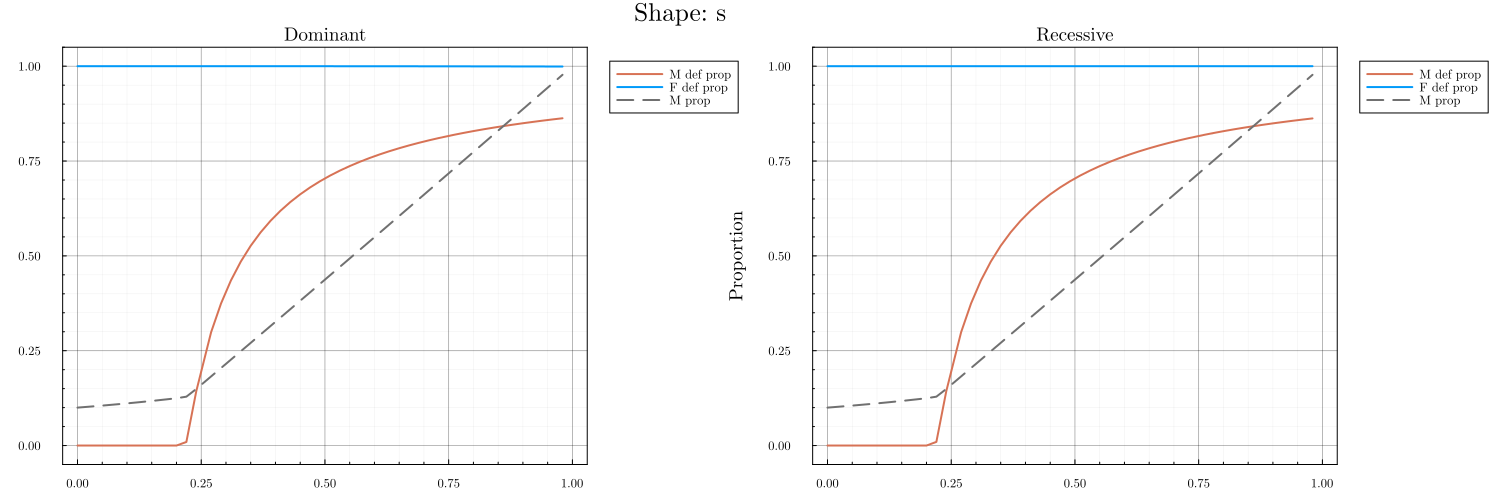

In [12]:
range_u = round.(collect(range(0, 1, 50)), digits = 2)

SHAPE = "s"
DOMINANT = true
f_dom, m_dom, m_prop_dom = change_u(P)
DOMINANT = false
f_rec, m_rec, m_prop_rec = change_u(P)

p1 = plot(range_u, [m_dom f_dom m_prop_dom], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Dominant")
p2 = plot(range_u, [m_rec f_rec m_prop_rec], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Recessive")

plot(p1, p2, layout = (1,2), size = (1500,500), plot_title = string("Shape: ", SHAPE))

In [13]:
function change_r(P) #Function to change male population, and calculating the defender proportion alongside
    range_u = round.(collect(range(0, 1, 50)), digits = 2)
    
    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["c"] = 8
    param["a"] = 2.58
    
    param["u"] = 0.1

    gentime = 1000

    female_data_a = []
    male_data_a = []
    male_prop_a = []

    for i in range_u
        param["r"] = i

        females = []
        males = []
        
        female_ls = []
        male_ls = []
        for t in 0:gentime
            females, males = nexgen(param, female_ls, male_ls)

            female_ls = copy(females)
            male_ls = copy(males)

            female_ls = female_ls ./ (sum(female_ls))
            male_ls = male_ls ./ (sum(male_ls))
        end
                
        if DOMINANT
            male_prop = sum(males) / (sum(males) + sum(females))
            male_def = (males[2] + males[4]) / sum(males)
            female_def = sum(females[4:end]) / sum(females)
        else
            male_prop = sum(males) / (sum(males) + sum(females))
            male_def = (males[2] + males[4]) / sum(males)
            female_def = sum(females[7:end]) / sum(females)
        end

        push!(female_data_a, female_def)
        push!(male_data_a, male_def)
        push!(male_prop_a, male_prop)

    end
    return female_data_a, male_data_a, male_prop_a
end

change_r (generic function with 1 method)

# Actual sim with P["r"] = i

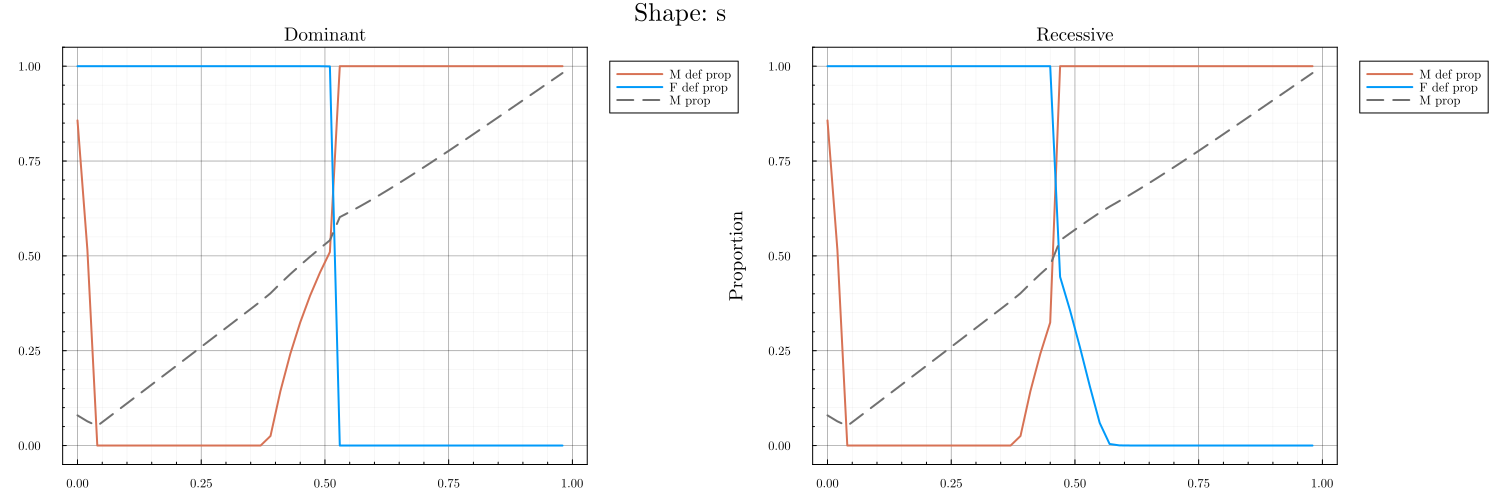

In [14]:
range_r = round.(collect(range(0, 1, 50)), digits = 2)

SHAPE = "s"
DOMINANT = true
f_dom, m_dom, m_prop_dom = change_r(P)
DOMINANT = false
f_rec, m_rec, m_prop_rec = change_r(P)

p1 = plot(range_r, [m_dom f_dom m_prop_dom], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Dominant")
p2 = plot(range_r, [m_rec f_rec m_prop_rec], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Recessive")

plot(p1, p2, layout = (1,2), size = (1500,500), plot_title = string("Shape: ", SHAPE))

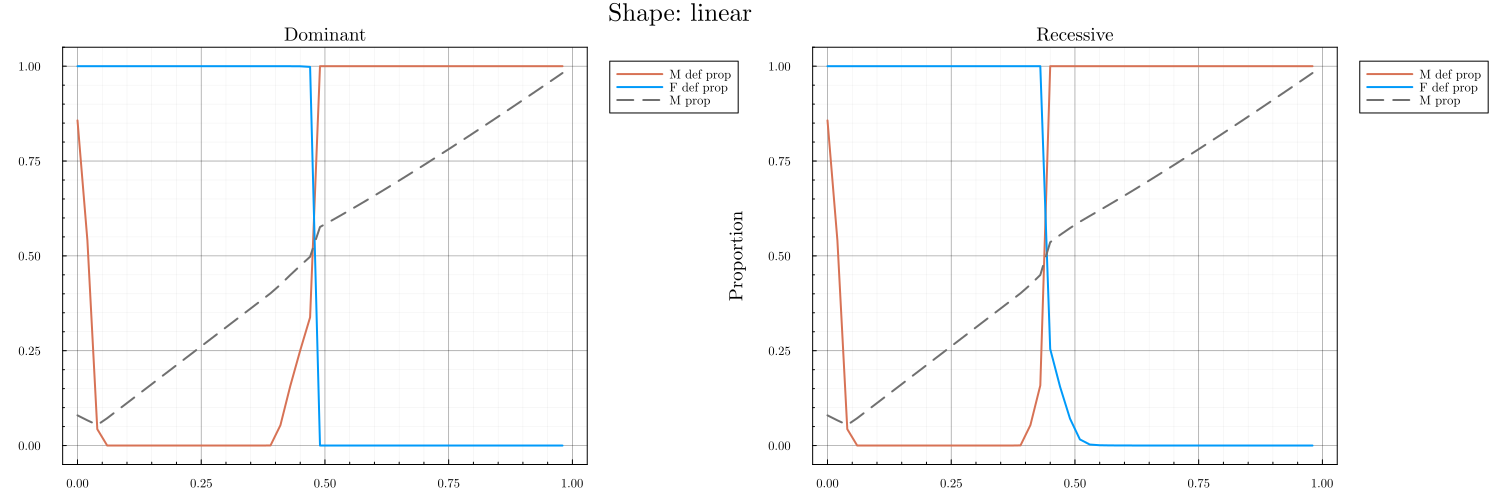

In [19]:
SHAPE = "linear"
DOMINANT = true
f_dom, m_dom, m_prop_dom = change_r(P)
DOMINANT = false
f_rec, m_rec, m_prop_rec = change_r(P)

p1 = plot(range_r, [m_dom f_dom m_prop_dom], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Dominant")
p2 = plot(range_r, [m_rec f_rec m_prop_rec], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Recessive")

plot(p1, p2, layout = (1,2), size = (1500,500), plot_title = string("Shape: ", SHAPE))

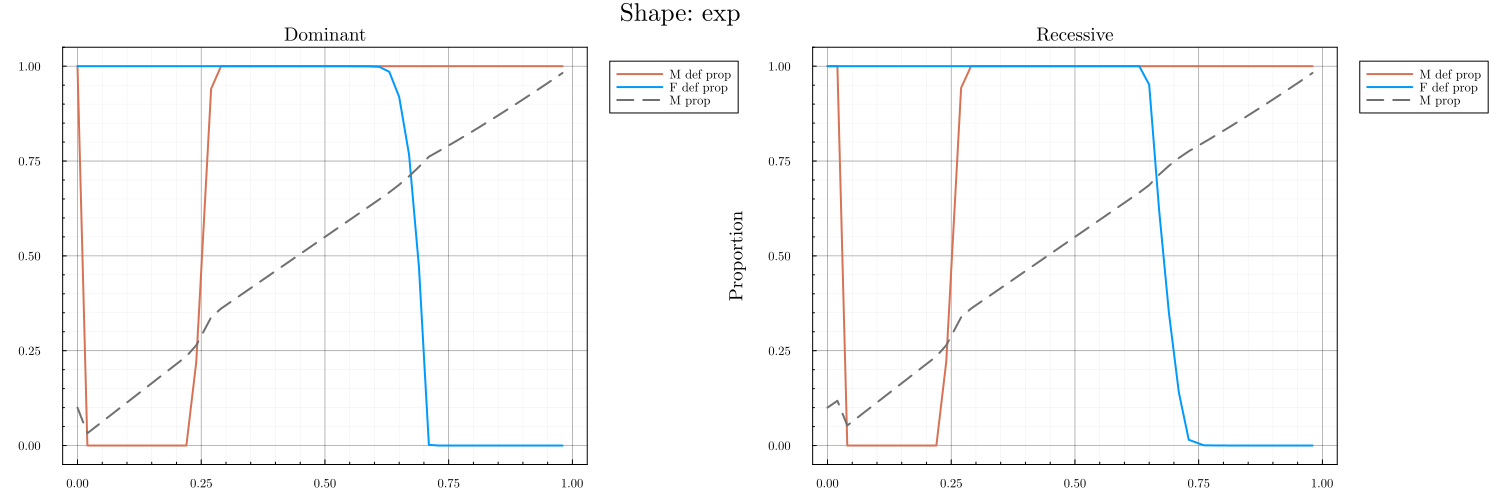

In [21]:
SHAPE = "exp"
DOMINANT = true
f_dom, m_dom, m_prop_dom = change_r(P)
DOMINANT = false
f_rec, m_rec, m_prop_rec = change_r(P)

p1 = plot(range_r, [m_dom f_dom m_prop_dom], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Dominant")
p2 = plot(range_r, [m_rec f_rec m_prop_rec], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Recessive")

plot(p1, p2, layout = (1,2), size = (1500,500), plot_title = string("Shape: ", SHAPE))

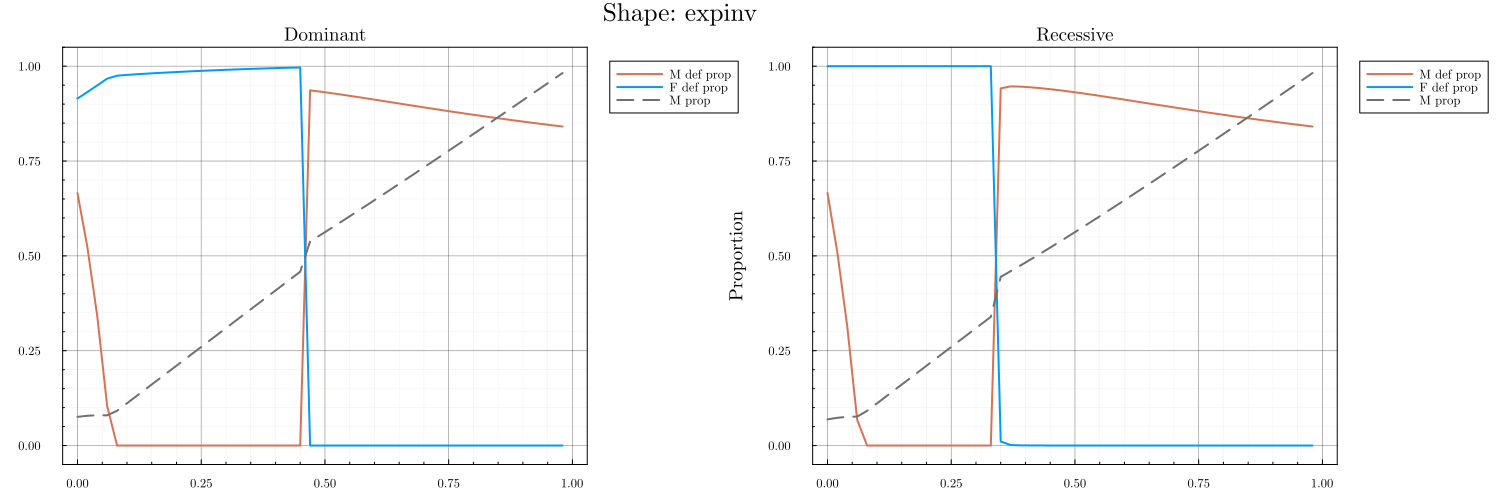

In [20]:
SHAPE = "expinv"
DOMINANT = true
f_dom, m_dom, m_prop_dom = change_r(P)
DOMINANT = false
f_rec, m_rec, m_prop_rec = change_r(P)

p1 = plot(range_r, [m_dom f_dom m_prop_dom], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Dominant")
p2 = plot(range_r, [m_rec f_rec m_prop_rec], labels = ["M def prop" "F def prop" "M prop"], lw = 2, linestyle = [:solid :solid :dash], xlabel = "Value of u", ylabel = "Proportion", ylims = (-0.05, 1.05), title = "Recessive")

plot(p1, p2, layout = (1,2), size = (1500,500), plot_title = string("Shape: ", SHAPE))

# Test

In [5]:
function change_r_pc(P) #Function to change male population, and calculating the defender proportion alongside
    range_r = round.(collect(range(0, 1, 50)), digits = 2)
    
    param = copy(P)
    param["pm"] = 0.1
    param["pf"] = 0.1

    param["c"] = 10
    param["a"] = 2.0
    
    param["u"] = 0.1

    gentime = 1000

    female_data_a = zeros(50)
    male_data_a = zeros(50)
    male_prop_a = zeros(50)

    for (idx, val) in enumerate(range_r)
        param["r"] = val

        females = []
        males = []
        
        female_ls = []
        male_ls = []
        for t in 0:gentime
            females, males = nexgen(param, female_ls, male_ls)

            female_ls = copy(females)
            male_ls = copy(males)

            female_ls = female_ls ./ (sum(female_ls))
            male_ls = male_ls ./ (sum(male_ls))
        end
                
        if DOMINANT
            male_prop = sum(males) / (sum(males) + sum(females))
            male_def = (males[2] + males[4]) / sum(males)
            female_def = sum(females[4:end]) / sum(females)
        else
            male_prop = sum(males) / (sum(males) + sum(females))
            male_def = (males[2] + males[4]) / sum(males)
            female_def = sum(females[7:end]) / sum(females)
        end

        female_data_a[idx] = female_def
        male_data_a[idx] = male_def
        male_prop_a[idx] = male_prop

    end
    return female_data_a, male_data_a, male_prop_a
end

0.9


0.8579578373720953
0.8599382880980219
-0.0019804507259265636


In [26]:
Threads.nthreads()

1

In [8]:
#f(21) x m(00) => f(10; 11), m(10; 11)

#Without mod:
println(s(1))

#Form 1
S1_v = 0
for k in 0:20
    mul1 = binomial(20, k) * (0.1)^k * (0.9)^(20-k)
    for i in 0:k
        mul2 = binomial(k, i) * (0.5)^i * (0.5)^(k - i)
        S1_v += mul1 * mul2 * s((20 - (0.2 * i))/20)
    end
end
println(S1_v)

#Form 2
S2_v = 0
for k in 0:20
    mul1 = binomial(20, k) * (0.1)^k * (0.9)^(20-k)
    for i in 0:k
        mul2 = binomial(k, i) * (0.5)^i * (0.5)^(k - i)
        for m in 0:i
            mul3 = binomial(i, m) * (0.2)^m * (0.8)^(i - m)
            S2_v += mul1 * mul2 * mul3 * s((20 - m)/20)
        end
    end
end
println(S2_v)

println(S1_v - S2_v)

0.9
0.8787320949798574
0.8797452904375525
-0.0010131954576950708


In [30]:
tst = round.(collect(range(0, 1, 10)), digits = 2)

10-element Vector{Float64}:
 0.0
 0.11
 0.22
 0.33
 0.44
 0.56
 0.67
 0.78
 0.89
 1.0

# Modifier Model

Will make new file after functions are made, for sake of clarity